In [1]:
import os
import json
import zipfile
from pathlib import Path

try:
  # See if you are running on colab
  from google.colab import drive 
  drive.mount('/content/gdrive', force_remount=True)
  path = "/content/gdrive/MyDrive/Assignment 3 Resources/Raw_7x7_train"
  # # Download the dataset
  # api_token = {"username":"tuankhoinguyen","key":"6b992b229c6a4d8f6a8b30d1c101507d"}
  # kaggle_path = Path('/root/.kaggle')
  # os.makedirs(kaggle_path, exist_ok=True)

  # with open (kaggle_path/'kaggle.json', 'w') as handl:
  #     json.dump(api_token,handl)
  # os.chmod(kaggle_path/'kaggle.json', 600)  
  # !kaggle competitions download -c grasp-and-lift-eeg-detection

  # # Unzipping datasets
  # for z in ['grasp-and-lift-eeg-detection','train']:
  #   print(f'Unzipping {z}.zip')
  #   with zipfile.ZipFile(f'{z}.zip', 'r') as zip_ref:
  #     zip_ref.extractall('')
  # print('All good!')
  # # Removing the zip files to save up VM space
  # !rm *.zip
except:
  pass

Mounted at /content/gdrive


In [30]:
try:
  # See if you are running on colab
  from google.colab import drive 

  # Download the dataset
  api_token = {"username":"tuankhoinguyen","key":"6b992b229c6a4d8f6a8b30d1c101507d"}
  kaggle_path = Path('/root/.kaggle')
  os.makedirs(kaggle_path, exist_ok=True)

  with open (kaggle_path/'kaggle.json', 'w') as handl:
      json.dump(api_token,handl)
  os.chmod(kaggle_path/'kaggle.json', 600)  
  !kaggle competitions download -c grasp-and-lift-eeg-detection

  # Unzipping datasets
  for z in ['grasp-and-lift-eeg-detection','train']:
    print(f'Unzipping {z}.zip')
    with zipfile.ZipFile(f'{z}.zip', 'r') as zip_ref:
      zip_ref.extractall('')
  print('All good!')
  # Removing the zip files to save up VM space
  !rm *.zip
except:
  pass

100% 1.02G/1.02G [01:31<00:00, 7.22MB/s]
100% 1.02G/1.02G [01:31<00:00, 12.0MB/s]
Unzipping grasp-and-lift-eeg-detection.zip
Unzipping train.zip
All good!


In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import tqdm
import pywt
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorboard.plugins import projector
import imageio
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [42]:
datas = glob.glob('/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/*')

In [44]:
datas[0], datas[2] = datas[2], datas[0]
# datas[0] = datas[2]
# datas[2] = x
datas


['/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series6__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series5__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series4__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series3__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series2__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Features/Copy of subj1_series1__f.npy']

In [45]:
x_tr = []

for data_path in datas:
    data = np.load(data_path).astype('float16')
    x_tr.append(data)

x_tr = np.concatenate(x_tr, axis=0)

In [46]:
print((x_tr.shape))

(1185498, 7, 7)


In [47]:
events = glob.glob('/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/*')
events

['/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series6_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series5_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series4_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series3_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series2_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Labels/Copy of subj1_series1_events.csv']

In [48]:
df_count = []

for e in tqdm.tqdm(events[:10]):
  df = pd.read_csv(e).iloc[:,1:]
  df_count.append(df)

y_tr = np.concatenate(df_count, axis=0)
print(y_tr.shape)

100%|██████████| 6/6 [00:00<00:00,  7.96it/s]

(1185498, 6)


In [77]:
test_datas = glob.glob('/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_features/*')
test_datas

['/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_features/Copy of subj1_series8__f.npy',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_features/Copy of subj1_series7__f.npy']

In [78]:
x_te = []

for data_path in test_datas:
    data = np.load(data_path).astype('float16')
    x_te.append(data)

x_te = np.concatenate(x_te, axis=0)

In [87]:
x_te2 = x_te[:-2]

In [79]:
test_events = glob.glob('/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_labels/*')
test_events

['/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_labels/Copy of subj1_series8_events.csv',
 '/content/gdrive/MyDrive/Assignment 3 Resources/Lightweight/Test_labels/Copy of subj1_series7_events.csv']

In [80]:
y_te = []

for e in tqdm.tqdm(test_events):
  df = pd.read_csv(e).iloc[:,1:]
  y_te.append(df)

y_te = np.concatenate(y_te, axis=0)
print(y_te.shape)

100%|██████████| 2/2 [00:00<00:00, 11.19it/s]

(236894, 6)


In [83]:
print(y_te)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [58]:
# # Updated ResNet34 for 7x7x1 input
# def identity_block(x, filter):
#     # the input tensor separated as residue 
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

# def convolutional_block(x, filter):
#     # the input tensor separated as residue 
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding='same', strides=(2,2))(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Processing Residue with conv(1,1)
#     x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides=(2,2))(x_skip)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

# shape = (7, 7, 1)  # Update input shape
# classes = 6

# # Setup Input Layer
# x_input = tf.keras.layers.Input(shape=shape)  # Update input shape
# x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
# x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)  # Update kernel_size and strides
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
# x = tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding='same')(x)  # Update pool_size

# # Define size of sub-blocks and initial filter size
# block_layers = [3, 4, 6, 3]
# filter_size = 64

# # Add the Resnet Blocks
# for i in range(len(block_layers)):
#     if i == 0:
#         # For block 1 Convolutional block not needed
#         for j in range(block_layers[i]):
#             x = identity_block(x, filter_size)
#     else:
#         # For all the other blocks
#         # The filter size will go on increasing by a factor of 2
#         filter_size = filter_size * 2
#         # One Convolutional Block followed by Identity blocks
#         x = convolutional_block(x, filter_size)
#         for j in range(block_layers[i] - 1):
#             x = identity_block(x, filter_size)

# # End Dense Network
# x = tf.keras.layers.AveragePooling2D((4, 4), padding='same')(x)  # Update pool_size
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(classes, activation='sigmoid')(x)

# model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
# model.summary()

In [102]:
# Lighter version without convolutional blocks

def identity_block(x, filter):
    # the input tensor separated as residue 
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # the input tensor separated as residue 
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding='same', strides=(2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides=(2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

shape = (7, 7, 1)  # Update input shape
classes = 6

# Setup Input Layer
x_input = tf.keras.layers.Input(shape=shape)  # Update input shape
x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(x)  # Update kernel_size and strides
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding='same')(x)  # Update pool_size

# Define size of sub-blocks and initial filter size
block_layers = [2, 2, 2, 2]
filter_size = 32

# Add the Resnet Blocks
for i in range(len(block_layers)):
    if i == 0:
        # For block 1 Convolutional block not needed
        for j in range(block_layers[i]):
            x = identity_block(x, filter_size)
    else:
        # For all the other blocks
        # The filter size will go on increasing by a factor of 2
        filter_size = filter_size * 2
        # One Convolutional Block followed by Identity blocks
        x = convolutional_block(x, filter_size)
        for j in range(block_layers[i] - 1):
            x = identity_block(x, filter_size)

# End Dense Network
x = tf.keras.layers.AveragePooling2D((4, 4), padding='same')(x)  # Update pool_size
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Update dense layer size
x = tf.keras.layers.Dense(classes, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 13, 13, 1)   0           ['input_14[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_304 (Conv2D)            (None, 13, 13, 32)   320         ['zero_padding2d_12[0][0]']      
                                                                                                  
 batch_normalization_271 (Batch  (None, 13, 13, 32)  128         ['conv2d_304[0][0]']      

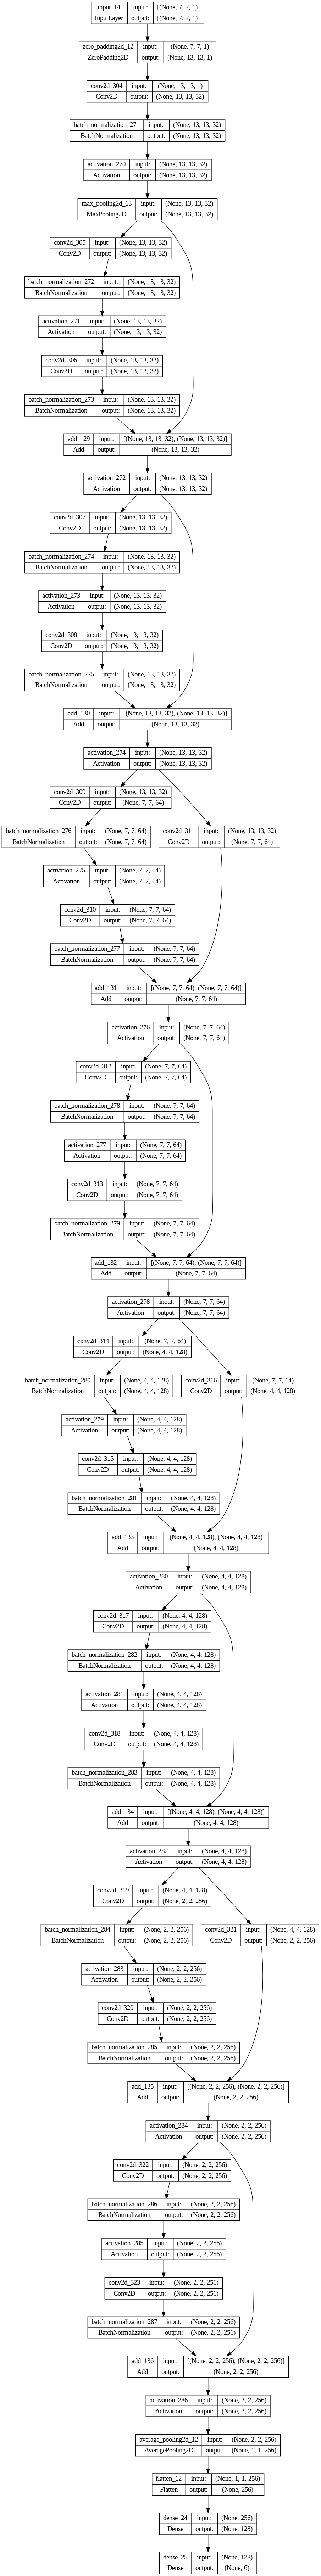

In [103]:
# Draw the model structure
tf.keras.utils.plot_model(model, to_file='model_resnet_plot.png', show_shapes=True, show_layer_names=True)

In [99]:
batch_size = 128
num_instance = 100000    # CHANGE AS REQUIRED

initial_learning_rate = 1e-3
decay_rate = 0.96
decay_steps = num_instance // batch_size

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)

# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['AUC']
)

print('Model compiled.')


Model compiled.


In [100]:
# Train the model
epochs = 5
history = model.fit(x_tr, y_tr, epochs=epochs, batch_size=batch_size)

Epoch 1/5
9262/9262 [==============================] - 194s 19ms/step - loss: 0.1081 - auc: 0.6951
Epoch 2/5
9262/9262 [==============================] - 177s 19ms/step - loss: 0.0762 - auc: 0.9212
Epoch 3/5
9262/9262 [==============================] - 176s 19ms/step - loss: 0.0533 - auc: 0.9716
Epoch 4/5
9262/9262 [==============================] - 177s 19ms/step - loss: 0.0403 - auc: 0.9855
Epoch 5/5
9262/9262 [==============================] - 176s 19ms/step - loss: 0.0318 - auc: 0.9912


In [101]:
# To evaluate the model with labels:
eval_history = model.evaluate(x_te2, y_te)

7403/7403 [==============================] - 38s 5ms/step - loss: 0.9769 - auc: 0.4986
